<a href="https://colab.research.google.com/github/fmassini/DataScienceCoderhouse/blob/main/Anteriores/ProyectoDS_ParteII_Massini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexto y problema comercial

La empresa Bosch es conocida por fabricar productos diversos para todo el mundo. Recientemente comenzó a producir un nuevo producto, el cual cuenta con 5 versiones distintas.

Este producto tiene la característica de producirse de una manera diferente a lo que la empresa está acostumbrada, por ello se han desarrollado nuevos procedimientos para llevar adelante la producción.

Estos procedimientos al ser nuevos, lamentablemente distan bastante del ideal; hace falta mucho estudio y trabajo para volverlos más eficientes.

De ahí nace la necesidad de este estudio, con la información que nos proporciona el desarrollador del producto, el sector logístico deberá buscar la manera de optimizar sus procesos, para poder cumplir con los plazos de abastecimiento a planta.

De ninguna manera puede suceder que la línea productiva pare por falta de piezas a la hora de montar, logística debe hacer lo indispensable para evitar este panorama. Y a su vez, hacerlo de la manera más eficiente posible (en cuanto a tiempos y costos).

## Contexto analítico y objetivo

El siguiente dataset contiene información sobre las piezas con su respectivo código (referencia) necesarias para construir distintas versiones de un producto en específico. Estas versiones difieren ya que algunas son más completas que otras, o tienen diferentes funciones, y por ende llevan distintas piezas en su ensamblado.

La mercadería viene en cajones llamados "bases" dentro de contenedores. A su vez, cada caja dentro de estas bases tiene dentro un número determinado de piezas (indicado en el dataset). En resumen, las piezas vienen en cajas, las cuales vienen en bases, las cuales a su vez vienen en contenedores. Toda esta información está detallada en el dataset, donde se indica incluso dimensiones, pesos y tipo de packaging de las bases o cajas.

Cada fila además aclara a que versión del producto pertenece la pieza, hay piezas comunes a todos y otras que no lo son. Una vez traidos los contenedores, las piezas deberán separarse en clases. La clase de una pieza determina de qué forma se ensambla, por lo que es necesario clasificar todo antes de comenzar a armar el producto.

Algunos puntos interesantes a ver en este estudio:

1. Existe un patrón en el contenido de los contenedores y bases? Este patrón se repite versión a versión?
2. Es necesario ingresar toda la mercadería para comenzar a producir? O es posible contar con todas las piezas sin haber ingresado toda la mercadería? Es decir, existe una combinación de contenedores menor al total, que me permite tener todos los tipos de piezas?
3. Qué volumen de ocupación conlleva el almacenar las piezas? A cuantas posiciones en una estantería equivaldría? Qué clase es la más voluminosa? Esto varía versión a versión?
4. Cuáles son las piezas críticas en cuanto a peso? Y en cuanto a volumen?

Todos estos puntos indudablemente ayudan a optimizar el proceso de ingreso de la mercadería, tanto para lo que es inspección como para almacenamiento y traslado. Es crítico que todas las piezas se encuentren en el lugar correcto a la hora de producir, y lo que buscamos es volver más eficiente el camino a dicho objetivo.

Fuente: https://docs.google.com/spreadsheets/d/1ouprDoTPf1Ua6wY1ZZ1FbcAgWx1ejaNl/edit?usp=drivesdk&ouid=111044325679429769254&rtpof=true&sd=true

In [ ]:
!git clone https://github.com/tctianchi/pyvenn.git
%cd pyvenn
!pip install venn
import venn #Importo librería especializada para generar diagramas de Venn de más de 3 sets (límite de Matplotlib)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display

### A continuación un resumen de las variables del DS:

In [ ]:
DSNX_IND=pd.read_excel('DS producto.xlsx',sheet_name='Hoja2')
DSNX_IND.head(17)

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
0,CLASE,Sector en el cual se ensambla esta pieza,F1,A
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
2,CONTENEDOR,Contenedor en el cual viene esta pieza,CMAU4908460,MRSU3285393
3,BASE,Base en la cual viene esta pieza,AF0001,MP001
4,TIPO BASE,Tipo de base,IRON FRAME,IRON FRAME
5,LARGO BASE,Largo de la base en mm,2110,2250
6,ANCHO BASE,Ancho de la base en mm,600,1700
7,ALTURA BASE,Altura de la base en mm,1200,1050
8,PESO BASE,Peso de la base en kg,205,861.0
9,CAJA,Caja en la cual viene esta pieza,AF0001,MC0072


In [ ]:
DSNX=pd.read_excel('DS producto.xlsx',sheet_name='Hoja1') #Cargo DS

In [ ]:
DSNX['CAJAS/BASE'] = DSNX.groupby(['BASE', 'VERSION'])['BASE'].transform('count') #Genero la columna CAJAS/BASE

In [ ]:
DSNX['REFS/BASE'] = DSNX.groupby(['BASE', 'VERSION'])['REFERENCIA'].transform('nunique') #Genero la columna REFS(distintas)/BASE

Como se explicaba en la introducción, para comenzar a producir es necesario clasificar las piezas en clases. Para esto se debe inspeccionar la mercadería que ingresa, aunque no es necesario hacerlo para todas las bases.
A continuación se generan filtros para clasificar las bases según si son inspeccionables o no. Estos criterios nacen de la operativa real.

In [ ]:
FILTRO1=DSNX['BASE'].str.startswith(('AF','AP')) #Filtro bases AF y AP, que son las que se podrían llegar a inspeccionar
FILTRO2=DSNX['CAJAS/BASE']>1 #Me quedo con las bases que tienen más de una caja (si tienen una caja sola, no hace falta inspeccionar)
FILTRO3=DSNX['TIPO CAJA']!="WOOD FRAME" #Elimino las bases con cajas de madera (no se inspeccionan)
FILTRO4=DSNX['REFS/BASE']>1 #Me quedo con las bases que tienen más de una referencia (bases monoproducto no hace falta inspeccionar)
DSNX['INSPECCIÓN'] = np.where(FILTRO1 & FILTRO2 & FILTRO3 & FILTRO4, 1, 0) #Genero columna que indica si la base es inspeccionable o no

In [ ]:
DSNX['REFS/CAJA'] = DSNX.groupby(['CAJA', 'VERSION'])['REFERENCIA'].transform('nunique') #Genero la columna REFS(distintas)/CAJA

In [ ]:
DSNX['VOLUMEN CAJA'] = ((DSNX['LARGO CAJA']/1000) * (DSNX['ANCHO CAJA']/1000) * (DSNX['ALTURA CAJA']/1000))/DSNX['REFS/CAJA'] #Genero la columna que indique cuanto volumen ocupa la referencia de la fila en cuestión. Si la caja trae múltiples referencias, divido entre esa cantidad

In [ ]:
DSNX['VOL TOTAL'] = DSNX.groupby(['VERSION','CLASE','REFERENCIA'])['VOLUMEN CAJA'].transform('sum') #La idea aquí es calcular cuanto volumen en total ocuparía cada referencia en su respectiva clase, por versión

## Exploratory data analysis

Ahora que conocemos el volumen que ocupa cada referencia, podemos calcular a cuantos pallets equivaldría dentro de una clase.
Recordemos que tenemos 2 tipos de bases, las inspeccionables y las que no.
Las inspeccionables se deberán revisar y armar pallets con la mercadería que contienen.
Lo más fácil para abastecer, es llevar pallets que contengan una sola referencia, ya que los que poseen muchas tienen el problema de que el operario debe "revolver" el pallet para encontrar una referencia en específico.
Tomaremos como criterio que armaremos pallets dedicados (una sola ref.) solamente de aquellas referencias que junten más de 2 pallets completos. El resto irá en pallets mixtos.

En cuanto a las bases no inspeccionables, se abastecen directamente, por ello les llamaremos "DIRECTOS".

In [ ]:
VOL_PALLET = 1.2*1.0*1.4 #Volumen que ocupa un pallet completo
DSNX['TIPO PALLET'] = np.where(DSNX['VOL TOTAL']>(2*VOL_PALLET), 'DEDICADO', 'MIXTO') #Si, por versión, una referencia junta más de 2 pallets en una clase, voy a armar pallets monoproducto (dedicados) de esa referencia, de lo contrario irá en pallets mezclados (mixtos).
DSNX['TIPO PALLET'] = np.where(DSNX['INSPECCIÓN']==0, 'DIRECTO', DSNX['TIPO PALLET']) #Esto anterior aplica solo a lo inspeccionable, lo otro se considera "directo"
DSNX

,CLASE,VERSION,CONTENEDOR,BASE,TIPO BASE,LARGO BASE,ANCHO BASE,ALTURA BASE,PESO BASE,CAJA,...,PESO CAJA,REFERENCIA,UNID/CAJA,CAJAS/BASE,REFS/BASE,INSPECCIÓN,REFS/CAJA,VOLUMEN CAJA,VOL TOTAL,TIPO PALLET
0,F1,M42,CMAU4908460,AF0001,IRON FRAME,2110,600,1200,205.0,AF0001,...,153.92,2804110-BU01,16,1,1,0,1,0.022100,0.132600,DIRECTO
1,F1,M42,CMAU4908460,AF0002,IRON FRAME,2110,600,1200,205.0,AF0002,...,153.92,2804110-BU01,16,1,1,0,1,0.022100,0.132600,DIRECTO
2,F1,M42,CMAU4908460,AF0003,IRON FRAME,2110,600,1200,205.0,AF0003,...,153.92,2804110-BU01,16,1,1,0,1,0.022100,0.132600,DIRECTO
3,F1,M42,CMAU4908460,AF0004,IRON FRAME,2110,600,1200,205.0,AF0004,...,153.92,2804110-BU01,16,1,1,0,1,0.022100,0.132600,DIRECTO
4,F1,M42,CMAU4908460,AF0005,IRON FRAME,2110,600,1200,205.0,AF0005,...,153.92,2804110-BU01,16,1,1,0,1,0.022100,0.132600,DIRECTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23599,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,6.81,7100004P201E,96,94,54,0,4,0.022770,0.022770,DIRECTO
23600,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,6.81,7100005P201E,96,94,54,0,4,0.022770,0.022770,DIRECTO
23601,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,6.81,7200004P201E,96,94,54,0,4,0.022770,0.022770,DIRECTO
23602,A,A42,MRSU3285393,MP001,IRON FRAME,2250,1700,1050,861.0,MC0074,...,6.81,7200005P201E,96,94,54,0,4,0.022770,0.022770,DIRECTO


### Aquí se presenta un diagrama final resumiendo toda la operativa:

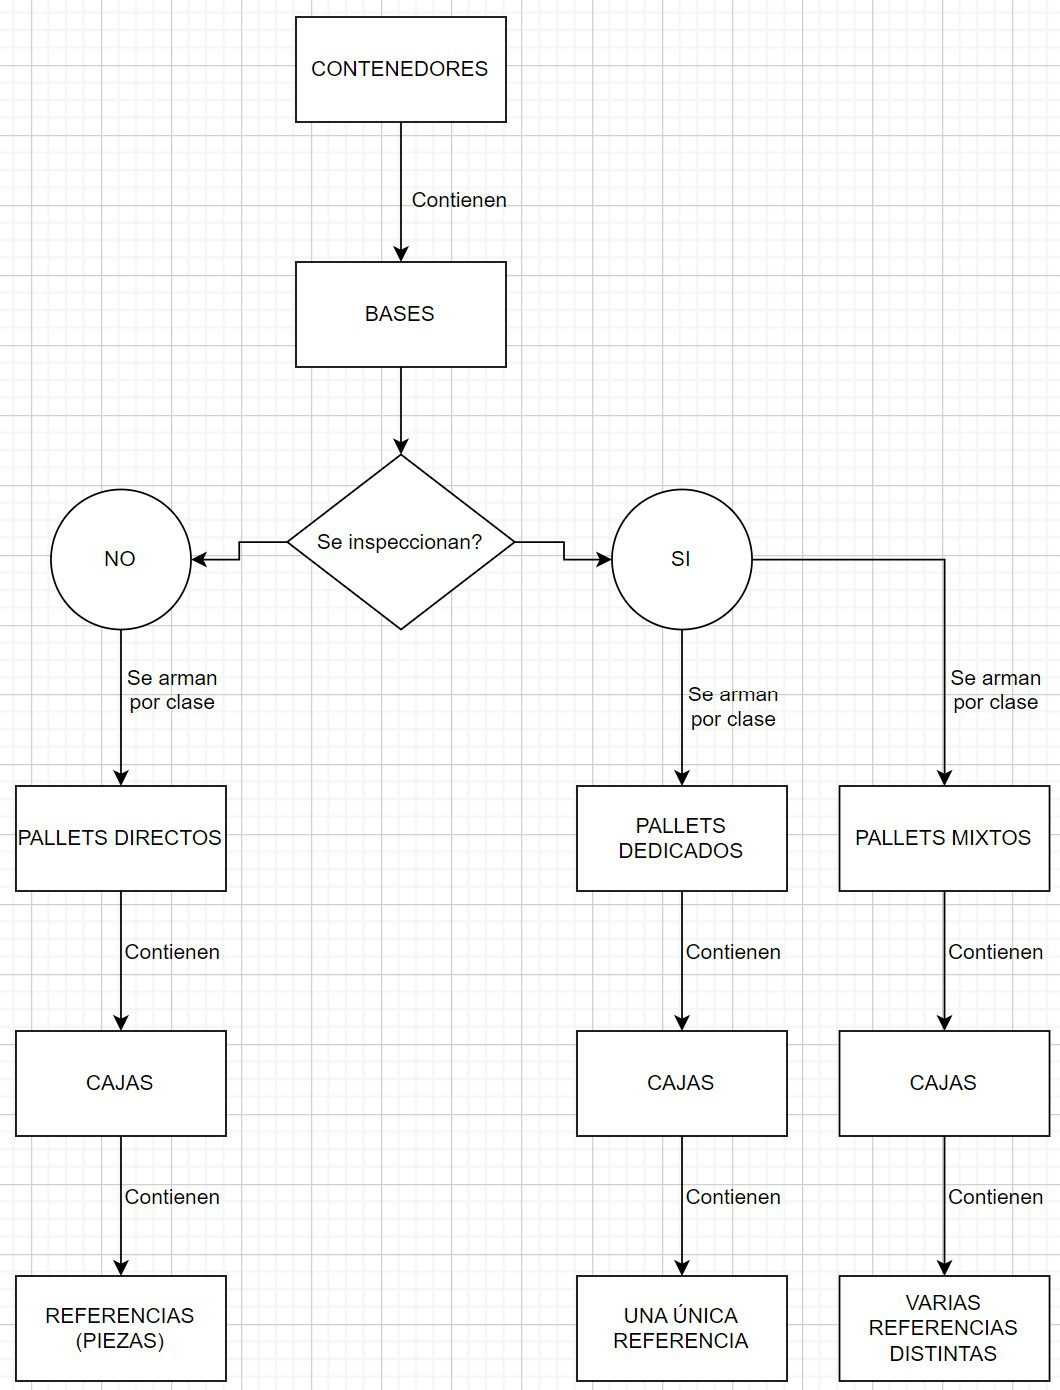

In [ ]:
imagen = Image.open('Flujo.jpg')
display(imagen)

### Graficamos cuantas referencias distintas pertenecen a cada clase, promediando por versión.

Matplotlib: GRÁFICO 1

A continuación el análisis, un pequeño glosario y el gráfico.

In [ ]:
DSNX_1 = DSNX.groupby(['CLASE', 'VERSION'])['REFERENCIA'].nunique().unstack() #Quiero saber cuantas referencias distintas hay en cada clase, por versión
DSNX_1['PROMEDIO'] =  DSNX_1.mean(axis=1, skipna=True) #Calculo el promedio por versión
DSNX_1

VERSION,A41,A42,M21,M41,M42,PROMEDIO
CLASE,,,,,,
A,66.0,73.0,66.0,66.0,68.0,67.800000
CA1,25.0,33.0,25.0,25.0,32.0,28.000000
CA2,33.0,33.0,37.0,38.0,38.0,35.800000
CA3,39.0,37.0,39.0,39.0,37.0,38.200000
CA4,44.0,45.0,44.0,44.0,43.0,44.000000
CA5,16.0,16.0,16.0,16.0,16.0,16.000000
CA6,29.0,31.0,29.0,29.0,31.0,29.800000
CA7,20.0,22.0,20.0,20.0,22.0,20.800000
CH1,15.0,15.0,14.0,15.0,15.0,14.800000


In [ ]:
DSNX_IND[(DSNX_IND['COLUMNA']=='REFERENCIA') | (DSNX_IND['COLUMNA']=='CLASE') | (DSNX_IND['COLUMNA']=='VERSION')]

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
0,CLASE,Sector en el cual se ensambla esta pieza,F1,A
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
15,REFERENCIA,Código de esta pieza,2804110-BU01,6900006P201D


Text(0.5, 1.0, 'REFERENCIAS DISTINTAS INVOLUCRADAS POR CLASE (PROMEDIO POR VERSIÓN)')

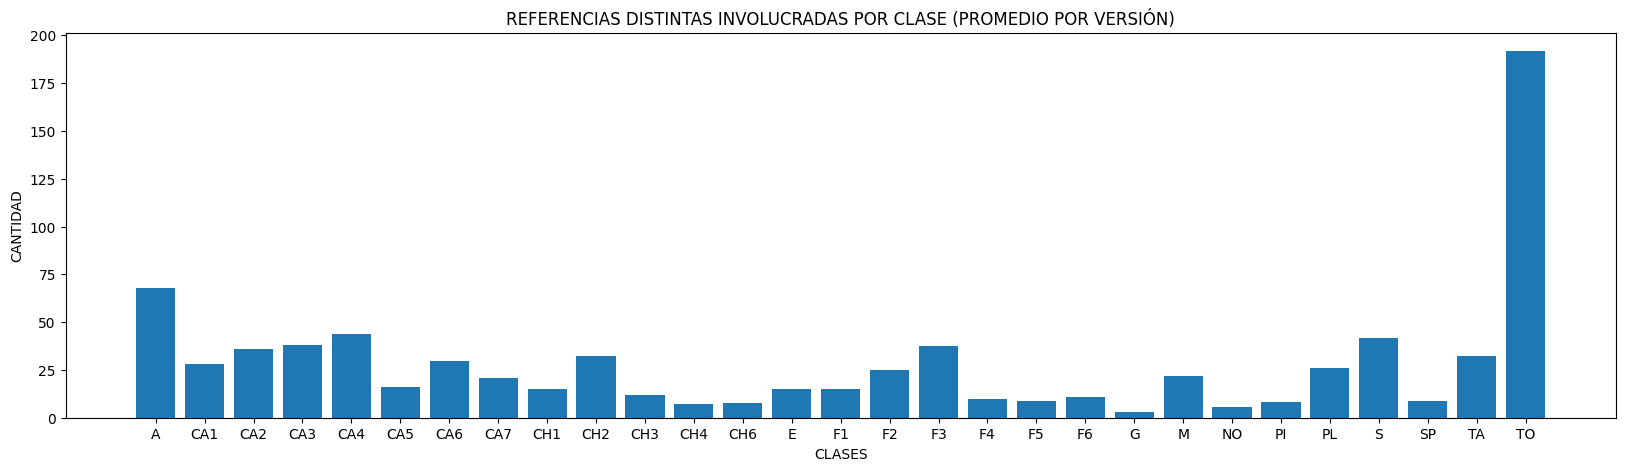

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(DSNX_1.index,DSNX_1['PROMEDIO'])
ax.set_xlabel('CLASES')
ax.set_ylabel('CANTIDAD')
ax.set_title('REFERENCIAS DISTINTAS INVOLUCRADAS POR CLASE (PROMEDIO POR VERSIÓN)')

Podemos concluir dos cosas:

La primera, es que en general todas las clases contienen más o menos la misma cantidad de referencias distintas. Solo la clase "A" y "TO" sobresalen.

La segunda, que la clase "TO" es la que contiene más referencias distintas por mucho. Esto tiene sentido, ya que las referencias pertenecientes a dicha clase son tornillería, de las cuales hay mucha variedad.

### Graficamos cuantas cajas vienen de cada referencia, diferenciando por versión.

Matplotlib: GRÁFICO 2A (sacando outliers)
Matplotlib: GRÁFICO 2B (completo)

A continuación el análisis, un pequeño glosario y el gráfico.

In [ ]:
DSNX_2 = DSNX.groupby(['REFERENCIA', 'VERSION'])['CAJA'].nunique().unstack() #Quiero saber cuantas cajas vienen por referencia, por versión
DSNX_2 = DSNX_2.fillna(0)
DSNX_2

VERSION,A41,A42,M21,M41,M42
REFERENCIA,,,,,
09103-06002,1.0,1.0,1.0,1.0,1.0
09103-06005,1.0,1.0,1.0,1.0,1.0
09103-06006,1.0,1.0,1.0,1.0,1.0
09103-06006-S111,1.0,1.0,1.0,1.0,1.0
09103-06007,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...
N807154,1.0,1.0,1.0,1.0,1.0
Q2734816F31,1.0,1.0,1.0,1.0,1.0
Q4400412,1.0,1.0,1.0,1.0,1.0


In [ ]:
DSNX_IND[(DSNX_IND['COLUMNA']=='REFERENCIA') | (DSNX_IND['COLUMNA']=='CAJA') | (DSNX_IND['COLUMNA']=='VERSION')]

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
9,CAJA,Caja en la cual viene esta pieza,AF0001,MC0072
15,REFERENCIA,Código de esta pieza,2804110-BU01,6900006P201D


Text(0.5, 1.0, 'CANTIDAD DE CAJAS POR REFERENCIA (SEPARADO POR VERSIÓN)')

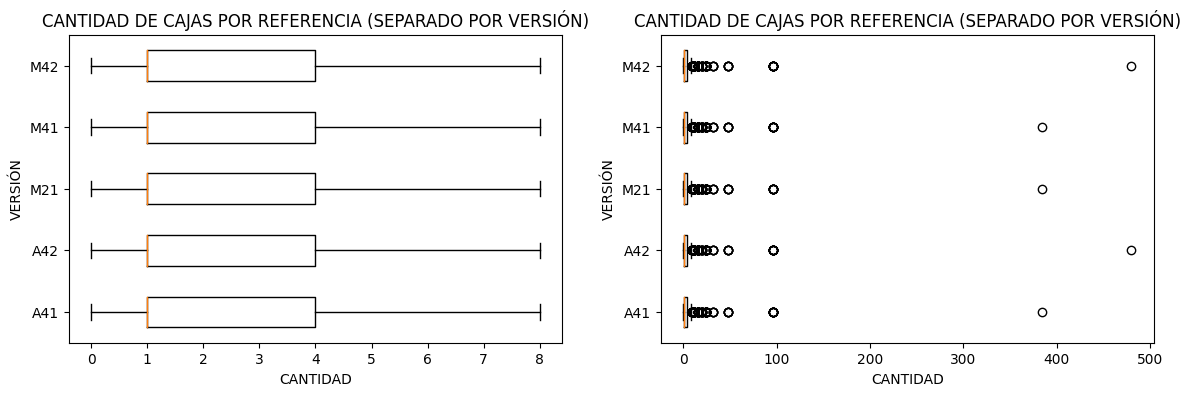

In [ ]:
fig, ax = plt.subplots(figsize=(14,4),nrows=1,ncols=2)
ax[0].boxplot(DSNX_2,vert=False,labels=DSNX_2.columns,showfliers=False) #Asi puedo sacar outliers
ax[0].set_xlabel('CANTIDAD')
ax[0].set_ylabel('VERSIÓN')
ax[0].set_title('CANTIDAD DE CAJAS POR REFERENCIA (SEPARADO POR VERSIÓN)')
ax[1].boxplot(DSNX_2,vert=False,labels=DSNX_2.columns,showfliers=True)
ax[1].set_xlabel('CANTIDAD')
ax[1].set_ylabel('VERSIÓN')
ax[1].set_title('CANTIDAD DE CAJAS POR REFERENCIA (SEPARADO POR VERSIÓN)')

Vemos que, para la mayoría de las referencias, abriendo entre 1 y 4 cajas ya contamos con el total de piezas de esa referencia.

Solo en casos muy puntuales tenemos referencias cuyo total viene en muchas cajas. No varía mucho por versión.

### Graficamos cuantas cajas vienen por base, diferenciando por versión y si la base es inspeccionable o no.

Seaborn: GRÁFICO 1

A continuación el análisis, un pequeño glosario y el gráfico.

In [ ]:
DSNX_3 = DSNX.drop_duplicates(subset=['VERSION', 'BASE']) #Quiero saber cuantas bases de cada tipo tengo por versión
DSNX_3

,CLASE,VERSION,CONTENEDOR,BASE,TIPO BASE,LARGO BASE,ANCHO BASE,ALTURA BASE,PESO BASE,CAJA,...,PESO CAJA,REFERENCIA,UNID/CAJA,CAJAS/BASE,REFS/BASE,INSPECCIÓN,REFS/CAJA,VOLUMEN CAJA,VOL TOTAL,TIPO PALLET
0,F1,M42,CMAU4908460,AF0001,IRON FRAME,2110,600,1200,205.00,AF0001,...,153.92,2804110-BU01,16,1,1,0,1,0.02210,0.1326,DIRECTO
1,F1,M42,CMAU4908460,AF0002,IRON FRAME,2110,600,1200,205.00,AF0002,...,153.92,2804110-BU01,16,1,1,0,1,0.02210,0.1326,DIRECTO
2,F1,M42,CMAU4908460,AF0003,IRON FRAME,2110,600,1200,205.00,AF0003,...,153.92,2804110-BU01,16,1,1,0,1,0.02210,0.1326,DIRECTO
3,F1,M42,CMAU4908460,AF0004,IRON FRAME,2110,600,1200,205.00,AF0004,...,153.92,2804110-BU01,16,1,1,0,1,0.02210,0.1326,DIRECTO
4,F1,M42,CMAU4908460,AF0005,IRON FRAME,2110,600,1200,205.00,AF0005,...,153.92,2804110-BU01,16,1,1,0,1,0.02210,0.1326,DIRECTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23503,A,A42,MRSU3285393,MF004,IRON FRAME,2250,1800,1000,406.57,MF004,...,187.58,6901000P201D,61,1,1,0,1,4.05000,7.4250,DIRECTO
23504,A,A42,MRSU3285393,MF005,IRON FRAME,2250,1800,1000,740.00,MF005,...,509.00,7301200-BU52,96,3,3,0,3,1.35000,1.3500,DIRECTO
23507,A,A42,MRSU3285393,MF006,IRON FRAME,2250,1800,1000,664.00,MF006,...,477.94,6801000P201D,61,1,1,0,1,4.05000,6.0750,DIRECTO
23508,A,A42,MRSU3285393,MF007,IRON FRAME,2250,1800,1000,616.44,MF007,...,505.44,7301300-BU50,48,2,2,0,2,2.02500,3.0375,DIRECTO


In [ ]:
DSNX_IND[(DSNX_IND['COLUMNA']=='CAJA') | (DSNX_IND['COLUMNA']=='BASE') | (DSNX_IND['COLUMNA']=='VERSION') | (DSNX_IND['COLUMNA']=='INSPECCIÓN')]

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
3,BASE,Base en la cual viene esta pieza,AF0001,MP001
9,CAJA,Caja en la cual viene esta pieza,AF0001,MC0072
19,INSPECCIÓN,Indica si el pallet se deberá inspeccionar o no,0,1


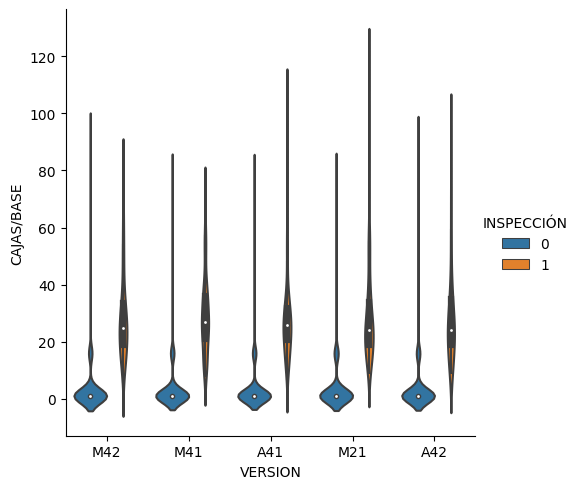

In [ ]:
sns.catplot(data=DSNX_3,kind='violin',y='CAJAS/BASE',x='VERSION',hue='INSPECCIÓN',split=False)

Como es de esperarse, en general las bases que no son inspeccionables traen pocas cajas, mientras que las inspeccionables en promedio traen una cantidad considerable de cajas.

No varía mucho por versión.

### Graficamos cuantas referencias coinciden por versión.

Matplotlib: GRÁFICO 3

A continuación el análisis, un pequeño glosario y el gráfico.

In [ ]:
DSNX_4 = DSNX.groupby(['REFERENCIA', 'VERSION'])['REFERENCIA'].nunique().unstack() #Con esto veo en que versión se usa cada referencia
DSNX_4 = DSNX_4.fillna(0)
DSNX_4['INDEX'] = DSNX_4.index
A41 = DSNX_4[DSNX_4.iloc[:, 0] == 1].iloc[:, 5]
A42 = DSNX_4[DSNX_4.iloc[:, 1] == 1].iloc[:, 5]
M21 = DSNX_4[DSNX_4.iloc[:, 2] == 1].iloc[:, 5]
M41 = DSNX_4[DSNX_4.iloc[:, 3] == 1].iloc[:, 5]
M42 = DSNX_4[DSNX_4.iloc[:, 4] == 1].iloc[:, 5]
DSNX_4

VERSION,A41,A42,M21,M41,M42,INDEX
REFERENCIA,,,,,,
09103-06002,1.0,1.0,1.0,1.0,1.0,09103-06002
09103-06005,1.0,1.0,1.0,1.0,1.0,09103-06005
09103-06006,1.0,1.0,1.0,1.0,1.0,09103-06006
09103-06006-S111,1.0,1.0,1.0,1.0,1.0,09103-06006-S111
09103-06007,1.0,1.0,1.0,1.0,1.0,09103-06007
...,...,...,...,...,...,...
N807154,1.0,1.0,1.0,1.0,1.0,N807154
Q2734816F31,1.0,1.0,1.0,1.0,1.0,Q2734816F31
Q4400412,1.0,1.0,1.0,1.0,1.0,Q4400412


In [ ]:
DSNX_IND[(DSNX_IND['COLUMNA']=='REFERENCIA') | (DSNX_IND['COLUMNA']=='VERSION')]

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
15,REFERENCIA,Código de esta pieza,2804110-BU01,6900006P201D


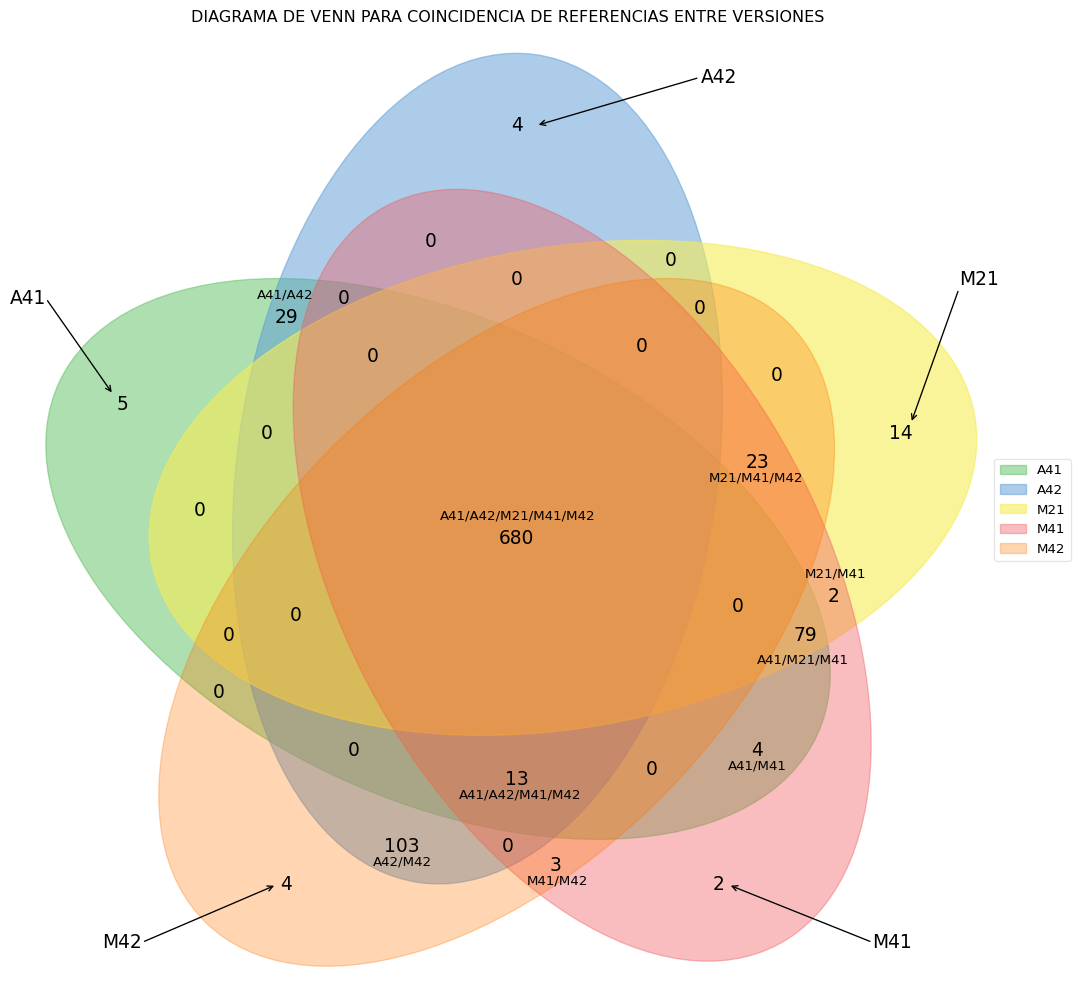

In [ ]:
labels = venn.get_labels([A41, A42, M21, M41, M42], fill=['number'])
fig, ax = venn.venn5(labels, names=['A41', 'A42', 'M21', 'M41', 'M42'])
ax.set_title('DIAGRAMA DE VENN PARA COINCIDENCIA DE REFERENCIAS ENTRE VERSIONES')

ax.annotate('A41/A42', xy=(0.24, 0.72), xytext=(0.24, 0.72))
ax.annotate('M21/M41/M42', xy=(0.71, 0.53), xytext=(0.71, 0.53))
ax.annotate('A41/M21/M41', xy=(0.76, 0.34), xytext=(0.76, 0.34))
ax.annotate('M21/M41', xy=(0.81, 0.43), xytext=(0.81, 0.43))
ax.annotate('A41/M41', xy=(0.73, 0.23), xytext=(0.73, 0.23))
ax.annotate('A41/A42/M41/M42', xy=(0.45, 0.20), xytext=(0.45, 0.20))
ax.annotate('A42/M42', xy=(0.36, 0.13), xytext=(0.36, 0.13))
ax.annotate('M41/M42', xy=(0.52, 0.11), xytext=(0.52, 0.11))
ax.annotate('A41/A42/M21/M41/M42', xy=(0.43, 0.49), xytext=(0.43, 0.49))
plt.annotate('', xy=(0.26, 0.11), xytext=(0.12, 0.05), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('', xy=(0.73, 0.11), xytext=(0.88, 0.05), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('', xy=(0.09, 0.62), xytext=(0.02, 0.72), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('', xy=(0.92, 0.59), xytext=(0.97, 0.73), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('', xy=(0.53, 0.90), xytext=(0.70, 0.95), arrowprops=dict(facecolor='black', arrowstyle='->'))
fig.show()

Se generan 5 conjuntos, cada uno correspondiente a una versión. Lo que se ilustra en este gráfico es la cantidad de referencias que coinciden entre estas versiones.

Como se puede ver, tenemos 680 referencias comunes a las 5 versiones, y luego distintas cantidades para cada combinación posible.

Esto sucede porque el producto tiene 3 funcionalidades:

1. Puede ser A o M.
2. Puede ser 4 o 2.
3. Puede ser 2 o 1.

Por ejemplo, los modelos A42 y M42 comparten 2 de las 3 funcionalidades, y esto se traduce en el gráfico como 103 referencias, la zona correspondiente es la 01001 (A41=0,A42=1,M21=0,M41=0,M42=1).

### Graficamos cuantos pallets de cada tipo pertenecen a cada clase, promediando por versión.

Seaborn: GRÁFICO 2

A continuación el análisis, un pequeño glosario y el gráfico.

In [ ]:
DSNX_5 = DSNX.pivot_table(index=['VERSION','CLASE'], columns='TIPO PALLET', values='VOLUMEN CAJA', aggfunc='sum') #Calculo el volumen total por clase, por versión
DSNX_5 = DSNX_5.fillna(0)
DSNX_5 = DSNX_5.groupby('CLASE').mean() #Promedio las versiones
DSNX_5 = DSNX_5/VOL_PALLET
DSNX_5 = DSNX_5.apply(np.ceil) #Redondeo para arriba
DSNX_5

TIPO PALLET,DEDICADO,DIRECTO,MIXTO
CLASE,,,
A,0.0,21.0,1.0
CA1,4.0,0.0,7.0
CA2,4.0,1.0,5.0
CA3,4.0,0.0,7.0
CA4,3.0,1.0,8.0
CA5,7.0,0.0,6.0
CA6,27.0,0.0,5.0
CA7,11.0,0.0,7.0
CH1,12.0,200.0,2.0


In [ ]:
DSNX_IND[(DSNX_IND['COLUMNA']=='CLASE') | (DSNX_IND['COLUMNA']=='CANT PALLETS') | (DSNX_IND['COLUMNA']=='TIPO PALLET') | (DSNX_IND['COLUMNA']=='VERSION') | (DSNX_IND['COLUMNA']=='VOL TOTAL')]

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
0,CLASE,Sector en el cual se ensambla esta pieza,F1,A
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
22,VOL TOTAL,Vol. que ocupa esta referencia en su clase,0.1356,0.156
23,CANT PALLETS,Cantidad de pallets que representa el VOL TOTAL,1,3
24,TIPO PALLET,"Indica pallet dedicado, mixto o directo",DIRECTO,DEDICADO


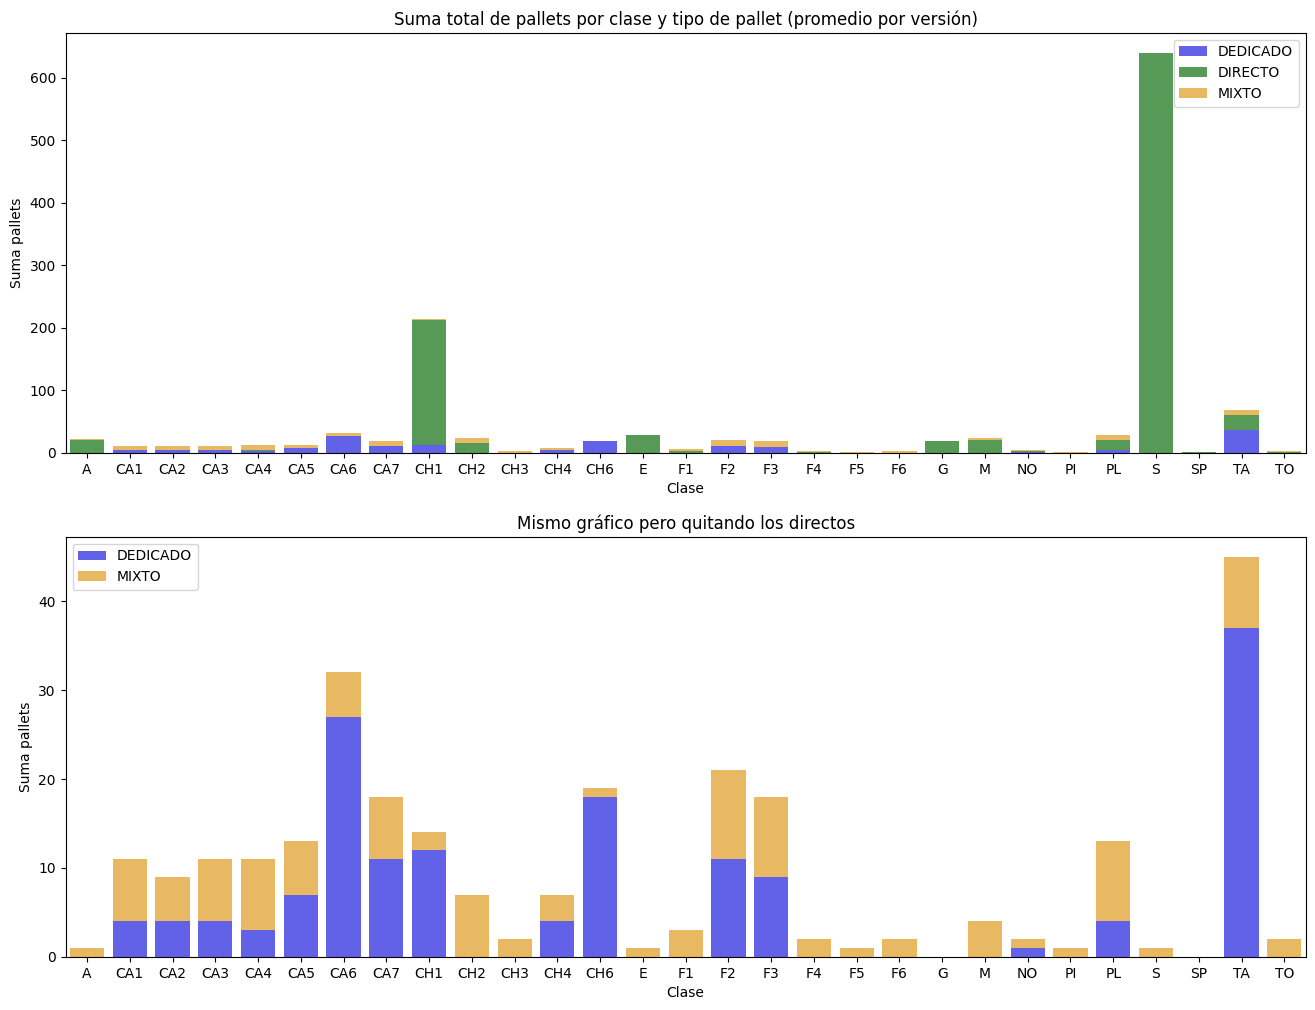

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='DEDICADO', color='blue', label='DEDICADO', alpha=0.7, ax=ax1)
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='DIRECTO', color='green', label='DIRECTO', alpha=0.7, bottom=DSNX_5['DEDICADO'], ax=ax1)
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='MIXTO', color='orange', label='MIXTO', alpha=0.7, bottom=DSNX_5['DEDICADO'] + DSNX_5['DIRECTO'], ax=ax1)

sns.barplot(data=DSNX_5, x=DSNX_5.index, y='DEDICADO', color='blue', label='DEDICADO', alpha=0.7, ax=ax2)
sns.barplot(data=DSNX_5, x=DSNX_5.index, y='MIXTO', color='orange', label='MIXTO', alpha=0.7, bottom=DSNX_5['DEDICADO'], ax=ax2)

ax1.set_title('Suma total de pallets por clase y tipo de pallet (promedio por versión)')
ax1.set_xlabel('Clase')
ax1.set_ylabel('Suma pallets')
ax1.legend()

ax2.set_title('Mismo gráfico pero quitando los directos')
ax2.set_xlabel('Clase')
ax2.set_ylabel('Suma pallets')
ax2.legend()

Las clases S, A y CH1 conllevan gran cantidad de pallets directos, esto sucede porque suelen estar compuestos por referencias que conllevan gran volumen, son piezas estructurales del producto.

Luego repetimos el mismo gráfico pero quitando los directos, para que se aprecie mejor la distribución entre dedicados y mixtos. Ya en este gráfico se empieza a dejar ver cuales son las clases que requerirán más espacio de almacenamiento.

### Graficamos un mapa de calor para ver la diferencia entre versiones.

Seaborn: GRÁFICO 3

A continuación el análisis, un pequeño glosario y el gráfico.

In [ ]:
#El objetivo aqui fue generar una matriz con la versión como índice y como columna, para poder ver la diferencia de piezas de versión a versión
DSNX_6 = pd.DataFrame(index=DSNX_4.columns[:5], columns=DSNX_4.columns[:5])
total=0
for k in DSNX_4.columns[:5]:
  for j in DSNX_4.columns[:5]:
    for i in DSNX_4.index:
      if DSNX_4.loc[i,j]!=DSNX_4.loc[i,k]:
        total+=1 #Voy recorriendo el DSNX_4 para cada par de versiones, si las dos valen 1 o 0, significa que ambas usan (o no) la referencia. Por ello solo sumo uno si los valores difieren
    DSNX_6.loc[k,j]=total
    total=0
DSNX_6 = DSNX_6.astype(float)
DSNX_6

VERSION,A41,A42,M21,M41,M42
VERSION,,,,,
A41,0.0,195.0,90.0,64.0,250.0
A42,195.0,0.0,267.0,249.0,63.0
M21,90.0,267.0,0.0,36.0,218.0
M41,64.0,249.0,36.0,0.0,194.0
M42,250.0,63.0,218.0,194.0,0.0


In [ ]:
DSNX_IND[(DSNX_IND['COLUMNA']=='REFERENCIA') | (DSNX_IND['COLUMNA']=='VERSION')]

,COLUMNA,DESCRIPCIÓN,EJEMPLO 1,EJEMPLO 2
1,VERSION,Versión del producto al cual pertenece esta pieza,M42,A42
15,REFERENCIA,Código de esta pieza,2804110-BU01,6900006P201D


Text(0.5, 1.0, 'DIFERENCIA DE USO DE REFERENCIAS ENTRE VERSIONES')

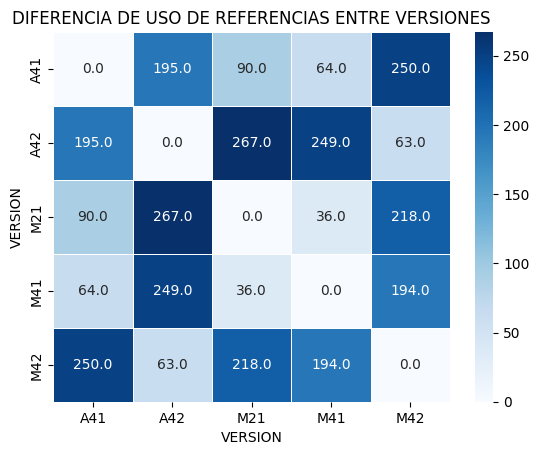

In [ ]:
sns.heatmap(DSNX_6,annot=True,fmt=".1f",linewidth=.5,cmap="Blues")
plt.title('DIFERENCIA DE USO DE REFERENCIAS ENTRE VERSIONES')

Obviamente la diagonal valdrá 0 ya que sería una comparación entre la misma versión, luego vemos que la que tiene más diferencias es la M21 con la A42.

Como se expicó anteriormente, esto tiene sentido ya que cada versión consta de 3 funciones. Las versiones A41 y A42 difieren solo en una función, mientras que las M21 y A42 difieren en las tres funciones (por ello son las que más difieren en las piezas que usan).